In [1]:
!pip install -q seaborn==0.13.* numpy==1.22.*

In [1]:
learnMSA_path = "../tmp_work/learnMSA" #ignore if learnMSA is already installed via pip/conda

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import pyplot, colors, rc
import matplotlib.cm as cm
import numpy as np
import yaml
import itertools
import sys
import tensorflow as tf
sys.path.insert(0, learnMSA_path)
from learnMSA.protein_language_models.EmbeddingBatchGenerator import EmbeddingBatchGenerator
from learnMSA.msa_hmm.Configuration import make_default
from learnMSA.msa_hmm.SequenceDataset import AlignedDataset
import learnMSA.protein_language_models.Common as Common

2024-05-23 06:38:32.333667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 06:38:32.412692: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 06:38:32.430148: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 06:38:32.860979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

In [2]:
col_names = ["dataset", "family", "num_seq", "num_ref_seq", "avg_len", "avg_ref_len", "sim", "SP", 
            "modeler", "TC", "column", "s", "h:m:s", "max_rss", "max_vms", "max_uss", 
            "max_pss", "io_in", "io_out", "mean_load", "cpu_time"]

In [3]:
with open("lm_experiments/config.yml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
config

{'language_models': ['esm2', 'protT5', 'proteinBERT'],
 'dimensions': [16, 32, 64],
 'activation': ['sigmoid', 'softmax'],
 'num_components': [1, 10, 32]}

In [4]:
dfs_lm = []
i = 0
for lm, dim, act, num_comp in itertools.product(*config.values()):
    experiment_name = f"{lm}_{dim}_{act}_{num_comp}"
    df = pd.read_csv("lm_experiments/results/learnMSA_language_"+experiment_name+".out", 
                        index_col=False, sep=' ', names=col_names)
    df["experiment"] = experiment_name
    df["lm"] = lm
    df["dim"] = dim
    df["act"] = act
    df["num_comp"] = num_comp
    df["index"] = i
    dfs_lm.append(df)
    i += 1

# Concatenate all dataframes into a single dataframe
merged_df_lm = pd.concat(dfs_lm, ignore_index=True)

In [5]:
means_lm = merged_df_lm.groupby(["dataset", "experiment"])[["TC", "SP", "column", "s"]].mean()
config_firsts = merged_df_lm.groupby(["dataset", "experiment"])[["lm", "dim", "act", "num_comp", "index"]].first()
summary_df_lm = pd.concat([means_lm, config_firsts], axis=1)
pd.set_option('display.max_colwidth', None)
summary_df_lm_sorted = summary_df_lm.sort_values("TC", ascending=False).reset_index().drop(columns=["dataset", "experiment"])
summary_df_lm_sorted

,TC,SP,column,s,lm,dim,act,num_comp,index
0,66.918085,87.647872,73.673404,1309.108800,protT5,32,softmax,10,28
1,66.829787,87.854255,73.778723,992.825860,protT5,16,softmax,1,21
2,66.700000,87.870213,73.705319,988.822460,protT5,16,sigmoid,32,20
3,66.451064,87.582979,73.193617,1351.273634,protT5,32,sigmoid,10,25
4,66.363830,87.420213,72.839362,1958.612983,protT5,64,sigmoid,32,32
5,66.302128,87.501064,73.044681,1362.228872,protT5,32,softmax,1,27
6,66.289362,87.212766,72.739362,1359.506219,esm2,32,sigmoid,32,8
7,66.253191,87.126596,72.836170,1037.624871,esm2,16,sigmoid,32,2
8,66.217021,87.219149,72.795745,1032.329067,esm2,16,sigmoid,1,0
9,66.110638,87.520213,72.615957,1909.094227,protT5,64,sigmoid,1,30


In [6]:
baseline_df = pd.read_csv("results/learnMSA.out", index_col=False, sep=' ', names=col_names)
TC, SP, col = baseline_df.groupby("dataset").mean().loc["homfam"][["TC", "SP", "column"]]

/tmp/ipykernel_358057/2321898447.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  TC, SP, col = baseline_df.groupby("dataset").mean().loc["homfam"][["TC", "SP", "column"]]


In [7]:
group_lm = summary_df_lm_sorted.groupby("lm").mean(numeric_only=True)[["TC", "SP", "column", "s"]]
group_lm["gain_TC"] = group_lm["TC"] - TC
group_lm["gain_SP"] = group_lm["SP"] - SP
group_lm["gain_column"] = group_lm["column"] - col
group_lm

,TC,SP,column,s,gain_TC,gain_SP,gain_column
lm,,,,,,,
esm2,65.139125,86.669208,71.581501,1524.729133,2.014657,1.474527,2.261288
protT5,65.993322,87.296454,72.682565,1415.442603,2.868853,2.101773,3.362352
proteinBERT,64.023700,85.884929,70.318853,1300.266210,0.899232,0.690248,0.998641


In [8]:
group_dim = summary_df_lm_sorted.groupby("dim").mean(numeric_only=True)[["TC", "SP", "column", "s"]]
group_dim["gain_TC"] = group_dim["TC"] - TC
group_dim["gain_SP"] = group_dim["SP"] - SP
group_dim["gain_column"] = group_dim["column"] - col
group_dim

,TC,SP,column,s,gain_TC,gain_SP,gain_column
dim,,,,,,,
16,65.380024,86.766194,71.968381,983.722044,2.255556,1.571513,2.648168
32,65.190012,86.709988,71.670035,1326.649421,2.065544,1.515307,2.349823
64,64.586111,86.374409,70.944504,1930.066482,1.461643,1.179728,1.624291


In [9]:
group_num_comp = summary_df_lm_sorted.groupby("num_comp").mean(numeric_only=True)[["TC", "SP", "s"]]
group_num_comp["gain_TC"] = group_num_comp["TC"] - TC
group_num_comp["gain_SP"] = group_num_comp["SP"] - SP
group_num_comp

,TC,SP,s,gain_TC,gain_SP
num_comp,,,,,
1,65.072222,86.605851,1410.350925,1.947754,1.411170
10,64.978073,86.591135,1414.173596,1.853605,1.396454
32,65.105851,86.653605,1415.913426,1.981383,1.458924


In [ ]:
# print dim and number of parameters for each language model
# takes a while to run, skip if not needed
for lm_name in summary_df_lm_sorted.lm.unique():
    lm, enc = Common.get_language_model(lm_name)
    num_param = sum(tf.size(v).numpy() for v in lm.model.variables)
    print(lm_name, "dim =", lm.dim, " param in millions = ", num_param / 1e6)

## Plots

In [11]:
# data
tools = ["learnMSA", "learnMSA_paper", "learnMSA_language2", 
         "famsa", "t_coffee", "clustalo", 
         "muscle", "mafft_sparsecore", "magus"]
num_tools = len(tools)
tool_name_map = {"learnMSA_language2" : "learnMSA2", 
                 "learnMSA_paper" : "learnMSA 1.0", 
                 "learnMSA" : "learnMSA 1.3", 
                 "famsa" : "FAMSA",
                 "muscle" : "MUSCLE",
                 "clustalo" : "Clustal Omega",
                 "magus" : "MAGUS",
                 "mafft" : "MAFFT",
                 "mafft_sparsecore" : "MAFFT Sparsecore",
                 "kalign" : "Kalign 3",
                 "t_coffee" : "T-Coffee\n(regressive)",
                 "t_coffee_sparsecore" : "T-Coffee\n(regressive, sc)"}
dataset_name_map = {"homfam" : "HomFam", 
                    "ext_homfam_huge" : "ExtHomFamHuge", 
                    "ext_homfam_xlarge" : "ExtHomFamXLarge",
                    "ext_homfam_large" : "ExtHomFamLarge",
                    "ext_homfam_medium" : "ExtHomFamMedium",
                    "ext_homfam_Small" : "ExtHomFamSmall",
                    "ext_homfam_smallish" : "ExtHomFamSmallish", }
merge_ext_homfam = True
exclude_data = ["homstrad"]

# plot settings
font_size = 12

In [12]:
# Create an empty list to store the dataframes
dfs = []

# Read each file and append its contents to the list
for i,tool in enumerate(tools):
    print(tool)
    filename = "results/"+tool+".out"
    df = pd.read_csv(filename, index_col=False, sep=' ', names=col_names)
    df["tool"] = tool
    df["overlength"] = df.avg_ref_len / df.avg_len
    df = df.set_index(df.dataset + "_" + df.family)
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
merged_df = pd.concat(dfs, ignore_index=True)

for d in exclude_data:
    merged_df = merged_df.drop(merged_df[merged_df.dataset == d].index)

def make_dataset_mask(df, include_ds):
    mask = df.dataset == include_ds[0]
    for d in include_ds[1:]:
        mask = np.logical_or(mask, df.dataset == d)
    return mask

if merge_ext_homfam:
    merged_df["raw_dataset"] = merged_df["dataset"].copy()
    merged_datasets = ["ext_homfam_large", "ext_homfam_medium", "ext_homfam_small"]
    merged_df.loc[make_dataset_mask(merged_df, merged_datasets), "dataset"] = "ext_homfam_smallish"

learnMSA
learnMSA_paper
learnMSA_language2
famsa
t_coffee
clustalo
muscle
mafft_sparsecore
magus


In [13]:
filter_out_failed_msa = True

all_zero = merged_df[(merged_df.SP == 0) & (merged_df.modeler == 0) & (merged_df.TC == 0) & (merged_df.column == 0)]
merged_df_all = merged_df
if filter_out_failed_msa:
    to_drop = all_zero[~all_zero.tool.astype("string").str.contains("learnMSA")].index
    print("removed failed msas:\n", merged_df.loc[to_drop])
    merged_df = merged_df.drop(to_drop)

removed failed msas:
               dataset     family  num_seq  num_ref_seq  avg_len  avg_ref_len  \
2756  ext_homfam_huge     kinase   949994            0  222.775          488   
2764  ext_homfam_huge   ABC_tran  2966699            0  169.241          354   
2772  ext_homfam_huge        sdr  1369993            0  177.362          361   
2784  ext_homfam_huge  Epimerase  1360465            0  178.021          410   
2788  ext_homfam_huge      TyrKc   941307            0  224.419          311   
3439  ext_homfam_huge   ABC_tran  2966699            0  169.241          354   

      sim   SP  modeler   TC  ...    max_vms    max_uss    max_pss  \
2756  0.0  0.0      0.0  0.0  ...  343716.55  114390.19  114399.71   
2764  0.0  0.0      0.0  0.0  ...  110196.46  104787.54  104794.34   
2772  0.0  0.0      0.0  0.0  ...  426946.79   96080.95   96095.02   
2784  0.0  0.0      0.0  0.0  ...  439975.58  128433.30  128434.53   
2788  0.0  0.0      0.0  0.0  ...  345052.87  114426.68  114430.38 

In [14]:
means = merged_df.groupby(["dataset", "tool"])[["TC", "SP", "column", "s"]].mean().reset_index()
means

,dataset,tool,TC,SP,column,s
0,ext_homfam_huge,famsa,37.946774,63.711290,40.362903,2918.747165
1,ext_homfam_huge,learnMSA,36.062903,60.083871,38.912903,6535.226855
2,ext_homfam_huge,learnMSA_language2,44.170968,66.896774,47.885484,11753.641074
3,ext_homfam_huge,learnMSA_paper,34.851613,55.853226,38.020968,5670.877979
4,ext_homfam_huge,muscle,41.268852,61.540984,45.127869,18599.078475
5,ext_homfam_huge,t_coffee,32.014035,55.301754,32.900000,18625.853877
6,ext_homfam_smallish,famsa,67.094318,82.712121,70.000379,13.205614
7,ext_homfam_smallish,learnMSA,65.731818,80.720455,69.128409,771.021077
8,ext_homfam_smallish,learnMSA_language2,66.978409,81.607955,70.700379,1371.686973
9,ext_homfam_smallish,learnMSA_paper,61.483333,77.345833,64.602652,742.019938


In [15]:
#gains
def get_tool(tool):
    return means[(means.tool == tool) & (means.dataset == "homfam")][["TC", "SP", "column", "s"]].reset_index()

get_tool("learnMSA_language2") - get_tool("famsa")

,index,TC,SP,column,s
0,2,5.828723,2.997872,8.080851,735.713457


In [16]:
merged_df.sort_values("sim")

,dataset,family,num_seq,num_ref_seq,avg_len,avg_ref_len,sim,SP,modeler,TC,...,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,tool,overlength,raw_dataset
1188,ext_homfam_smallish,Glyco_hydro_2,54968,3,98.0938,129,10.6,20.9,26.6,1.8,...,125746.34,12668.20,12724.13,1.67,113.36,190.84,2058.47,learnMSA_language2,1.315068,ext_homfam_large
3025,ext_homfam_smallish,Glyco_hydro_2,54968,3,98.0938,129,10.6,20.9,21.3,6.2,...,6726.45,1022.44,1026.15,0.00,0.02,972.67,10158.99,muscle,1.315068,ext_homfam_large
607,ext_homfam_smallish,Glyco_hydro_2,54968,3,98.0938,129,10.6,15.4,17.0,4.4,...,105150.66,6353.45,6436.56,0.00,0.61,165.33,812.63,learnMSA_paper,1.315068,ext_homfam_large
1769,ext_homfam_smallish,Glyco_hydro_2,54968,3,98.0938,129,10.6,15.4,15.2,1.8,...,7361.06,568.96,572.49,0.00,0.02,872.88,278.36,famsa,1.315068,ext_homfam_large
2350,ext_homfam_smallish,Glyco_hydro_2,54968,3,98.0938,129,10.6,7.3,9.5,6.2,...,7620.21,1687.69,1691.91,0.11,567.89,1148.67,14.84,t_coffee,1.315068,ext_homfam_large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,ext_homfam_smallish,mthina,1143,3,57.9536,32,93.5,100.0,100.0,100.0,...,125993.33,5865.92,5977.98,1.98,3.25,109.71,206.99,learnMSA,0.552166,ext_homfam_small
2551,ext_homfam_smallish,mthina,1143,3,57.9536,32,93.5,100.0,100.0,100.0,...,7002.06,1058.45,1155.46,0.00,1.68,902.05,5.94,t_coffee,0.552166,ext_homfam_small
3226,ext_homfam_smallish,mthina,1143,3,57.9536,32,93.5,100.0,100.0,100.0,...,6129.90,119.36,133.24,0.00,0.02,407.42,15.58,muscle,0.552166,ext_homfam_small
1389,ext_homfam_smallish,mthina,1143,3,57.9536,32,93.5,100.0,100.0,100.0,...,125733.97,5863.72,5919.82,1.99,6.47,111.34,241.86,learnMSA_language2,0.552166,ext_homfam_small


In [17]:
dataset_props = merged_df[merged_df.tool == "learnMSA"].groupby("dataset").mean()[["num_seq", "num_ref_seq", "avg_len", "avg_ref_len", "sim"]]
dataset_props[["num_seq", "num_ref_seq", "avg_len", "avg_ref_len"]] = dataset_props[["num_seq", "num_ref_seq", "avg_len", "avg_ref_len"]].astype(int)
dataset_num = merged_df[merged_df.tool == "learnMSA"].groupby("dataset").count()["family"]
dataset_props = pd.concat([dataset_props, dataset_num], axis=1)
dataset_props

/tmp/ipykernel_358057/4102511353.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset_props = merged_df[merged_df.tool == "learnMSA"].groupby("dataset").mean()[["num_seq", "num_ref_seq", "avg_len", "avg_ref_len", "sim"]]


,num_seq,num_ref_seq,avg_len,avg_ref_len,sim,family
dataset,,,,,,
ext_homfam_huge,517400,6,152,331,31.050000,62
ext_homfam_smallish,29583,5,129,212,41.214015,264
ext_homfam_xlarge,166974,5,150,303,33.352239,67
homfam,8006,8,148,259,38.152128,94


In [18]:
min_props = merged_df[merged_df.tool == "learnMSA"].groupby("dataset").min()[["num_seq", "num_ref_seq", "avg_len", "avg_ref_len", "sim"]]
min_props

,num_seq,num_ref_seq,avg_len,avg_ref_len,sim
dataset,,,,,
ext_homfam_huge,254325,3,22.8962,39,13.2
ext_homfam_smallish,207,3,11.2973,31,10.6
ext_homfam_xlarge,101015,3,21.0592,48,16.3
homfam,93,5,23.2513,39,17.8


In [19]:
max_props = merged_df[merged_df.tool == "learnMSA"].groupby("dataset").max()[["num_seq", "num_ref_seq", "avg_len", "avg_ref_len", "sim"]]
max_props

,num_seq,num_ref_seq,avg_len,avg_ref_len,sim
dataset,,,,,
ext_homfam_huge,2966699,26,399.711,891,63.9
ext_homfam_smallish,99836,41,513.488,938,93.5
ext_homfam_xlarge,245767,27,381.152,885,69.1
homfam,93681,41,427.824,938,76.5


In [20]:
means

,dataset,tool,TC,SP,column,s
0,ext_homfam_huge,famsa,37.946774,63.711290,40.362903,2918.747165
1,ext_homfam_huge,learnMSA,36.062903,60.083871,38.912903,6535.226855
2,ext_homfam_huge,learnMSA_language2,44.170968,66.896774,47.885484,11753.641074
3,ext_homfam_huge,learnMSA_paper,34.851613,55.853226,38.020968,5670.877979
4,ext_homfam_huge,muscle,41.268852,61.540984,45.127869,18599.078475
5,ext_homfam_huge,t_coffee,32.014035,55.301754,32.900000,18625.853877
6,ext_homfam_smallish,famsa,67.094318,82.712121,70.000379,13.205614
7,ext_homfam_smallish,learnMSA,65.731818,80.720455,69.128409,771.021077
8,ext_homfam_smallish,learnMSA_language2,66.978409,81.607955,70.700379,1371.686973
9,ext_homfam_smallish,learnMSA_paper,61.483333,77.345833,64.602652,742.019938


In [31]:
import matplotlib.patheffects as pe
pd.options.mode.chained_assignment = None

def make_barplots(datasets, merged_df, means, 
                  score1 = "SP", score2 = "TC", 
                  tools_drop_from_small_plots=[], name="barplots",
                  wspace=0.2):

    sns.set_style("whitegrid")

    fig, axes = plt.subplot_mosaic([datasets[:1]*(len(datasets)-1), datasets[1:]], 
                                   figsize=((len(datasets)-1)*max(4, len(means.tool.unique())-1)*0.6, 7),
                                   gridspec_kw={"height_ratios":[1.5,1]})
    fig.subplots_adjust(wspace=wspace, hspace=0.6)

    def map_tool_names(data):
        data.tool = data.tool.astype('category')
        data.tool = data.tool.cat.rename_categories(tool_name_map)
        data.tool = data.tool.astype('object')

    #get the permutation that sorts the tools by their mean TC score
    sorted_ds_tools = means.groupby(["dataset", "tool"])["TC"].mean().sort_values(ascending=False).index
    means_sorted = means.set_index(["dataset", "tool"]).loc[sorted_ds_tools].reset_index()


    def get_tool_colors(palette_name):
        base_order = list(means_sorted.tool.unique())
        palette = sns.color_palette(palette_name, len(base_order))
        return {tool_name_map[t] : palette[i] for i,t in enumerate(base_order)}


    for i,d in enumerate(datasets):

        ax = axes[d]

        data = merged_df[merged_df.dataset == d]
        order = means_sorted[means_sorted.dataset == d]
        
        if i > 0:
            for t in tools_drop_from_small_plots:
                data = data.drop(data[data.tool == t].index)
                order = order.drop(order[order.tool == t].index)
 
        min_tc = order[score2].min()
        max_sp = order[score1].max()

        #runtimes as lables before relabeling
        for t in data.tool.unique():
            seconds = means[np.logical_and(means.dataset == d, means.tool == t)].s.to_numpy()[0]
            hours = seconds / 60 / 60
            label = f"{np.round(hours, 2)} h"
            ax.text(tool_name_map[t], min_tc+(max_sp-min_tc)/2, label, ha='center', 
                    color="black", size=0.9*font_size if i==0 else 0.7*font_size,
                    path_effects=[pe.withStroke(linewidth=3, foreground="white")])

        #rename labels more appropriately
        map_tool_names(data)
        map_tool_names(order)
        order = list(order.tool)

        tool_colors = get_tool_colors("deep")

        #render sp scores 
        bar1 = sns.barplot(
            data=data, x="tool", y=score1, hue="tool", order=order,
            err_kws={"color": ".4", "linewidth": 1.5}, capsize=.2,
            linewidth=1, edgecolor=".6", 
            palette=tool_colors, alpha=.5, ax=ax)

        #render tc scores as stacked bars on top
        bar3 = sns.barplot(data=data, x="tool", y=score2, hue="tool", order=order, 
            errorbar=None,               
            palette=get_tool_colors("dark"), alpha=.5, ax=ax)

        num_seq = int(dataset_props.loc[d].family)
        depth = int(dataset_props.loc[d].num_seq)
        sim = np.round(dataset_props.loc[d].sim, 1)
        ax.set_title(dataset_name_map[d] + f"\n m={num_seq}, n={depth}, s={sim}",  size=font_size)
        ax.set_xlabel("")
        ax.set_ylim(min_tc, ax.get_ylim()[1]-3)
        for item in ax.get_xticklabels():
            item.set_rotation(20)
            item.set_size(font_size if i==0 else 0.8*font_size)
        if i > 1:
            ax.set_ylabel("")
        else:
           ax.set_ylabel(f"{score1} (fade)\n{score2} (solid)", rotation=90, size=font_size)
        #save as pdf
        plt.savefig(f"plots/{name}.pdf", format="pdf", bbox_inches="tight")
        plt.savefig(f"plots/{name}.png", format="png", bbox_inches="tight")
    return tool_colors

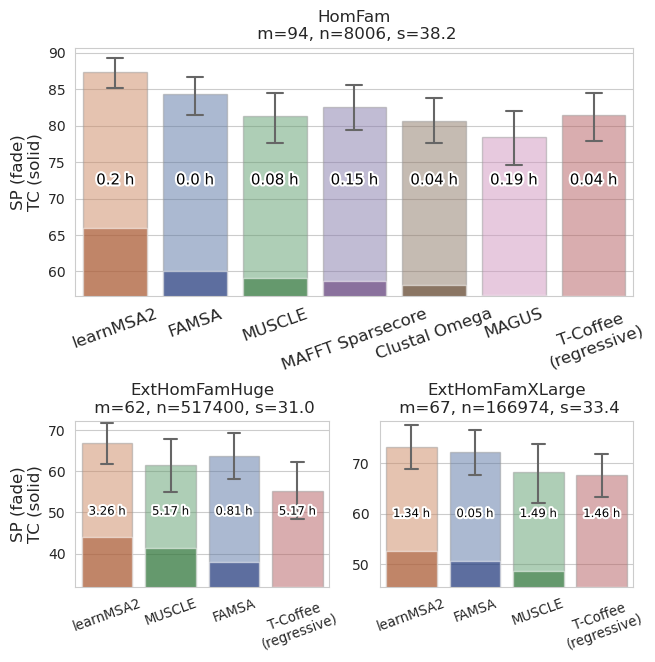

In [32]:
# make a stacked bar plot that compares SP and TC scores 
# for each dataset
if merge_ext_homfam:
    datasets = ["homfam", "ext_homfam_huge", "ext_homfam_xlarge"]#, "ext_homfam_smallish"]
else:
    datasets = ["homfam", "ext_homfam_huge", "ext_homfam_xlarge", 
                "ext_homfam_large", "ext_homfam_medium", "ext_homfam_small"]
manuscript_merged_df = merged_df.drop(merged_df[(merged_df.tool == "learnMSA") | (merged_df.tool == "learnMSA_paper")].index)
manuscript_means = means.drop(means[(means.tool == "learnMSA") | (means.tool == "learnMSA_paper")].index)
tool_colors_barplot = make_barplots(datasets, manuscript_merged_df, manuscript_means, 
            score1 = "SP", score2 = "TC",
            tools_drop_from_small_plots=["magus", "mafft", "clustalo", "mafft_sparsecore", "kalign"])

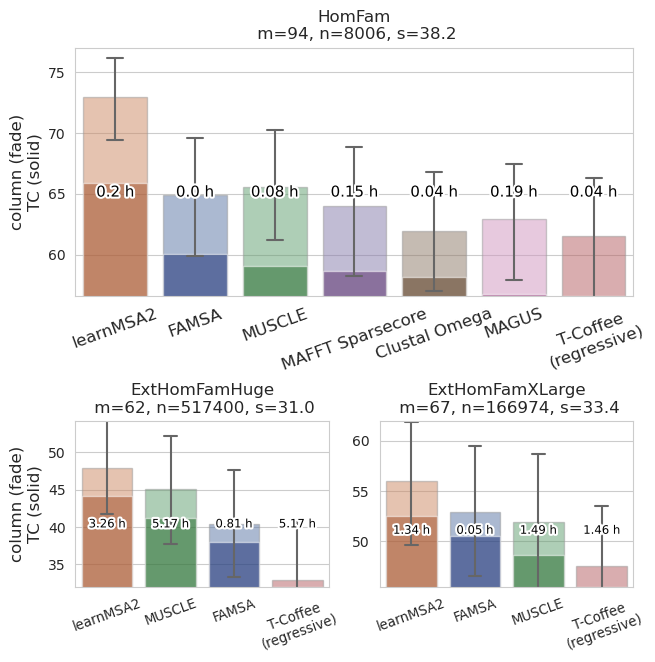

In [29]:
make_barplots(datasets, manuscript_merged_df, manuscript_means, 
            score1 = "column", score2 = "TC",
            tools_drop_from_small_plots=["magus", "mafft", "clustalo", "mafft_sparsecore", "kalign"],
            name="barplot_supp")

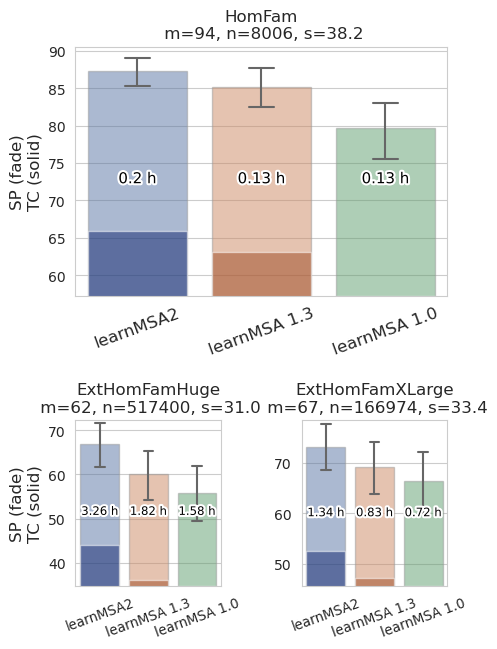

In [30]:
supp_merged_df = merged_df.drop(merged_df[(merged_df.tool == "famsa") | (merged_df.tool == "muscle") | (merged_df.tool == "t_coffee") | (merged_df.tool == "clustalo") | (merged_df.tool == "mafft") | (merged_df.tool == "mafft_sparsecore") | (merged_df.tool == "magus")].index)
supp_means = means.drop(means[(means.tool == "famsa") | (means.tool == "muscle") | (means.tool == "t_coffee") | (means.tool == "clustalo") | (means.tool == "mafft") | (means.tool == "mafft_sparsecore") | (means.tool == "magus")].index)
make_barplots(datasets, supp_merged_df, supp_means, name="barplots_supp2", wspace=0.55)

In [31]:
def get_column_df(tool, dataset, score_type="SP"):
    return merged_df[np.logical_and(merged_df.tool == tool, merged_df.dataset == dataset)][["family", score_type]].set_index("family")

def diff_scores(tool1, tool2, dataset, score_type="SP"):
    return (get_column_df(tool1, dataset, score_type) - get_column_df(tool2, dataset, score_type)).sort_values(by=score_type)

In [32]:
diff_scores("learnMSA_language2", "famsa", dataset="ext_homfam_huge")

,SP
family,
MHC_II_alpha_NC,-60.9
grs,-44.0
molybdopterin,-37.2
MHC_II_C,-28.3
Cyclodex_gly_tran,-19.8
...,...
Phage_integrase,23.2
FAD-oxidase_NC,29.7
Extradiol_dioxy,37.9


In [33]:
overall = merged_df[merged_df.dataset != "homstrad"].groupby("tool").mean()[["SP", "TC", "column"]]
overall

/tmp/ipykernel_232099/3485662187.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  overall = merged_df[merged_df.dataset != "homstrad"].groupby("tool").mean()[["SP", "TC", "column"]]


,SP,TC,column
tool,,,
clustalo,80.641489,58.195745,61.907447
famsa,79.174538,59.753183,62.893224
learnMSA,77.349076,58.914168,62.748049
learnMSA_language2,79.672485,61.875565,66.215195
learnMSA_paper,73.555647,55.105955,58.610062
mafft_sparsecore,82.500000,58.695745,64.015957
magus,78.401064,56.769149,62.912766
muscle,76.258848,58.479218,62.701646
t_coffee,74.661411,54.787967,57.664108


/tmp/ipykernel_131962/1709875284.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis")


rho famsa = -0.15391827865409108
rho t_coffee = -0.2750957233188825
rho muscle = -0.012509535769389185
669 alignments 462 positive alignments
learnMSA score with similarity rho = 0.4912635574979457
rho = -0.14622991896745352


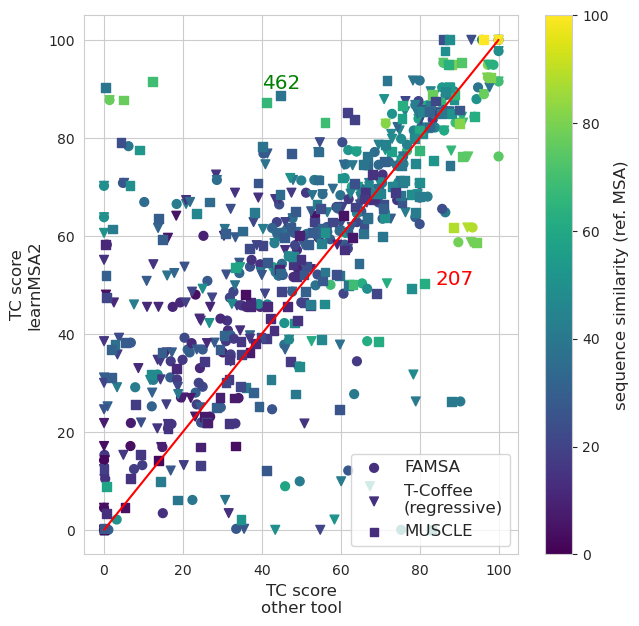

In [35]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

score_type = "TC"
x_tools = ["famsa", "t_coffee", "muscle"]
y_tool = "learnMSA_language2"
cmap = plt.cm.get_cmap("viridis")
#setting to true shows the proportion of the theoretical improvements assuming a maximum score of 100
plot_proportional_improvements = False 

# compute the maximum achieved score over all non-pLM tools for each family
max_scores = merged_df_all.loc[merged_df_all.tool != "learnMSA_language"].groupby(["dataset", "family"])[score_type].max()
max_scores = max_scores.reset_index()
max_scores = max_scores.loc[max_scores.dataset == "homfam"]
max_scores = max_scores.set_index(max_scores.dataset + "_" + max_scores.family)[score_type]

dataset = ["homfam", "ext_homfam_huge", "ext_homfam_xlarge", "ext_homfam_large", "ext_homfam_medium", "ext_homfam_small"]

x_list, y_list, s_list = [], [], []

#plot everything in one scatterplot, color the points with sequence similarity and choose markers to identify the method
#plot best_lm against all other tools
markers = ["o", "v", "s", "P", "X", "D", "p", "h", "8", ">", "<", "^", "d", "*", "H", "1", "2"]
y_df = merged_df_all[merged_df_all.tool == y_tool]
y_df.index = y_df.dataset.astype("str") + "_" + y_df.family.astype("str")
num_msa = 0
num_msa_pos = 0
for i,x_tool in enumerate(x_tools):
    if plot_proportional_improvements:
        lm_score = y_df.set_index(df.dataset + "_" + df.family)[score_type]
        other_score = dfs[i].loc[dfs[i].dataset == "homfam"][score_type]
        diff = lm_score - other_score
        prop_score = np.maximum(-1., np.minimum(1., diff / (100. - np.maximum(lm_score, other_score))))
        plt.plot(y_df.sim, 
                prop_score,
                markers[i-1],
                label=tools[i])
    else:
        x_df = merged_df_all[merged_df_all.tool == x_tool]
        x_df.index = x_df.dataset.astype("str") + "_" + x_df.family.astype("str")
        x = x_df[make_dataset_mask(x_df, dataset)][score_type]
        y = y_df[make_dataset_mask(y_df, dataset)][score_type]
        sim = y_df[make_dataset_mask(y_df, dataset)].sim
        corrcoef = np.corrcoef(y-x, sim)
        print("rho", x_tool, "=", corrcoef[0,1])
        num_msa += x.shape[0]
        num_msa_pos += np.sum((y-x) >= 0)
        ax.scatter(x=x, 
                    y=y, 
                    c=sim, 
                    marker=markers[i],
                    label=tool_name_map[x_tool],
                    s=40,
                    cmap=cmap)
        x_list.append(x)
        y_list.append(y)
        s_list.append(sim)
                    
#plot the correct and wrong alignment numbers
print(num_msa, "alignments", num_msa_pos, "positive alignments")
ax.text(40, 90, str(num_msa_pos), color="green", fontsize=font_size*1.2)
ax.text(84, 50, str(num_msa-num_msa_pos), color="red", fontsize=font_size*1.2)

#correlation between score differences and similarity
print("learnMSA score with similarity rho =", np.corrcoef(y, sim)[0,1])
x = np.concatenate(x_list)
y = np.concatenate(y_list)
sim = np.concatenate(s_list)
corrcoef = np.corrcoef(y-x, sim)
print("rho =", corrcoef[0,1])

if plot_proportional_improvements:
    #draw red horizontal line
    plot = ax.plot([0,100],[0,0], color='red')
    ax.set_xlabel("sequence similarity (ref. MSA)", size=font_size)
    ax.set_ylabel("adjusted "+score_type+" difference", size=font_size)
else:
    #draw red diagonal line
    plot = ax.plot([0,100],[0,100], color='red')
    ax.set_xlabel(score_type+" score\nother tool", size=font_size)
    ax.set_ylabel(score_type+" score\nlearnMSA2", size=font_size)
    cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(0, 100), cmap=cmap), ax=ax)
    cbar.set_label(label="sequence similarity (ref. MSA)", size=font_size)
    #plt.xlim(30,102)
    #plt.ylim(30,102)
plt.legend(loc="lower left" if plot_proportional_improvements else "lower right", prop={'size': 0.8*font_size if plot_proportional_improvements else font_size})
plt.savefig("plots/seqsim.pdf", format="pdf", bbox_inches="tight")
plt.savefig("plots/seqsim.png", format="png", bbox_inches="tight")
plt.show()

In [84]:
def heatmap_probs(filename, i, j, ax, 
                    scoring_model_config : Common.ScoringModelConfig, 
                    file_fmt="fasta",
                    start1=0, start2=0, len1=50, len2=50, 
                    custom_title=None,
                    path_alignments=[], path_colors=[], path_labels=[], label_settings=[{}]):
    ''' Plots the heatmap of the emission probabilities of the language model for the i-th and j-th sequence in the file.
        filename: path to the file containing the sequences to embed
        i: index of the first sequence
        j: index of the second sequence
        lm_name: name of the language model to use
        dim: reduced dimension of the scoring model
        use_finetuned_lm: whether to use the finetuned version of the language model
        start1: start position of the first sequence
        start2: start position of the second sequence
        len1: length of the first sequence
        len2: length of the second sequence
        custom_title: a string used as title
    '''
    emb_gen = EmbeddingBatchGenerator(scoring_model_config, shuffle=False)
    config = make_default(1)
    data = AlignedDataset(filename, file_fmt)
    emb_gen.configure(data, config)
    emb = emb_gen(np.array([i,j]))[-1]
    attention_map = emb_gen.scoring_model.layers[-1](emb[0], emb[1], a_is_reduced=True, b_is_reduced=True, training=False)[0]

    def compute_path(col1, col2):
        M = np.array([[col1[u] == col2[v] for u in range(min(len(seq1), len1))] for v in range(min(len(seq2), len2))])
        return np.argwhere(M)

    seq1 = str(data.get_record(i).seq).upper().replace('-', '').replace('.', '')
    seq2 = str(data.get_record(j).seq).upper().replace('-', '').replace('.', '')
    col1 = data.get_column_map(i)
    col2 = data.get_column_map(j)
    annot = [["x" if col1[u] == col2[v] else "" for v in range(start2, min(len(seq2), start2+len2))] for u in range(start1, min(len(seq1), start1+len1))] 
    if custom_title is None: 
        sub_title = lm_name + " dim=" + str(dim)
    else:
        sub_title = custom_title
    sns.heatmap(attention_map[start1:min(len(seq1), start1+len1), start2:min(len(seq2), start2+len2)], 
                cmap="OrRd",
                annot=annot, 
                fmt="",
                xticklabels=seq2[start2:start2+len2], 
                yticklabels=seq1[start1:start1+len1],
                ax = ax, 
                annot_kws={"fontsize" : max(4, 500 / max(len1, len2)), "alpha": 0.9},
                cbar_kws = {"pad": -0.1, "shrink": 0.6, "location": "bottom", "anchor" : (0.1, 1.)},
                ).set_title(sub_title, {"fontsize": 1.2*font_size})
    #set x label
    ax.set_xlabel(f"{data.seq_ids[j]}/{start2}-{start2+len2} (target)", {"fontsize": 1.2*font_size})
    ax.set_ylabel(f"{data.seq_ids[i]}/{start1}-{start1+len1} (query)", {"fontsize": 1.2*font_size})
    #rotate x and y tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=0.6*font_size)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=0.5*font_size)
    for file, color, label, settings in zip(path_alignments, path_colors, path_labels, label_settings):
        path_data = AlignedDataset(file, fmt="fasta")
        c1 = path_data.get_column_map(i)[start1:min(len(seq1), start1+len1)]
        c2 = path_data.get_column_map(j)[start2:min(len(seq2), start2+len2)]
        path = compute_path(c1, c2)
        ax.plot(path[:,0], path[:,1], color=color, lw=4, alpha=0.35)
        text_offset = settings["offset"] if "offset" in settings else 0
        pos = settings["pos"] if "pos" in settings else 0.5
        n = int(path.shape[0]*pos)
        ax.text(path[n,0]+text_offset, path[n,1], label, color=color, fontsize=font_size, ha="center", va="center")

In [85]:
# find the largest improvements resulting from embeddings

learnMSA_df = dfs[tools.index("learnMSA")]
learnMSA_df = learnMSA_df[learnMSA_df.dataset == "homfam"]
mean_over_runs = merged_df_lm.groupby(["dataset", "family"]).mean(numeric_only=True).reset_index()
mean_over_runs = mean_over_runs.set_index(mean_over_runs.dataset + "_" + mean_over_runs.family) 
diff = mean_over_runs.SP - learnMSA_df.SP
diff.sort_values(ascending=False).head(10)


homfam_rvp             38.429630
homfam_rhv             27.122222
homfam_peroxidase      20.522222
homfam_DEATH            9.703704
homfam_cytb             5.883333
homfam_lyase_1          5.772222
homfam_tRNA-synt_2b     5.692593
homfam_KAS              5.403704
homfam_il8              4.862963
homfam_sti              4.701852
Name: SP, dtype: float64

In [86]:
def plot_comparison(family, seq1, seq2, start1, start2, len1, len2, ax, no_label=False, label_offset1=0, label_offset2=0, label_pos1=0.5, label_pos2=0.5):
    heatmap_probs("data/homfam/refs/"+family, seq1, seq2, ax, 
                    Common.ScoringModelConfig(lm_name="protT5", dim=32, activation="softmax", scaled=False),
                    start1=start1, start2=start2, len1=len1, len2=len2, 
                    path_alignments=["outputs/learnMSA/projections/homfam/"+family, "lm_experiments/outputs/learnMSA_language_protT5_32_softmax_10/projections/homfam/"+family], 
                    path_colors=[sns.color_palette("dark")[2], sns.color_palette("dark")[0]], 
                    path_labels=["", ""] if no_label else ["learnMSA\nViterbi alignment", "learnMSA2\nViterbi alignment"],
                    label_settings=[{"offset" : label_offset1, "pos" : label_pos1}, {"offset" : label_offset2, "pos" : label_pos2}],
                    custom_title=family)

Computing all embeddings (this may take a while).
Computing all embeddings (this may take a while).
Computing all embeddings (this may take a while).


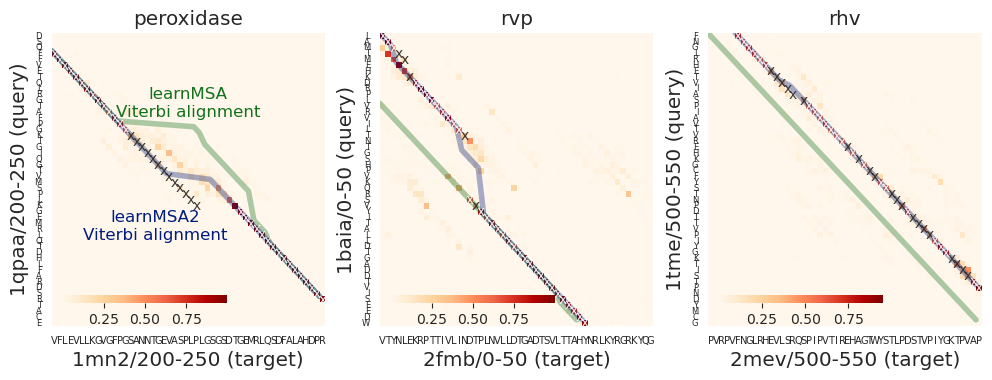

In [87]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
#plot_comparison(family="lyase_1", seq1=1, seq2=2, start1=274, start2=214, len1=60, len2=60, ax=ax[0,0], label_offset1=18, label_pos1=0.5, label_offset2=-13, label_pos2=0.6)
plot_comparison(family="peroxidase", seq1=0, seq2=2, start1=200, start2=200, len1=50, ax=ax[0], len2=50, label_offset1=16, label_pos1=0.25, label_offset2=-18, label_pos2=0.7)
plot_comparison(family="rvp", seq1=4, seq2=5, start1=0, start2=0, len1=50, len2=50, ax=ax[1], no_label=True)
plot_comparison(family="rhv", seq1=0, seq2=1, start1=500, start2=500, len1=50, len2=50, ax=ax[2], no_label=True)

In [42]:
fig.tight_layout()
fig.savefig("plots/probs_and_paths.pdf")
fig.savefig("plots/probs_and_paths.png") 

### Runtime vs sequence length

In [21]:
import sys
sys.path.insert(0, "/home/beckerf/brain/learnMSA/")
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
#add max sequence lengths

In [22]:
for dataset in merged_df.raw_dataset.unique():
    for family in merged_df[merged_df.raw_dataset == dataset].family.unique():
        fasta = SequenceDataset(f"data/{dataset}/train/{family}")
        merged_df.loc[(merged_df.raw_dataset == dataset) & (merged_df.family == family), "max_len"] = int(fasta.seq_lens.max())
        merged_df.loc[(merged_df.raw_dataset == dataset) & (merged_df.family == family), "min_len"] = int(fasta.seq_lens.min())

In [23]:
merged_df["s/num_seq"] = merged_df["s"]/merged_df["num_seq"]
merged_df["max_rss/num_seq"] = merged_df["max_rss"]/merged_df["num_seq"]

In [24]:
tool_colors_barplot

NameError: name 'tool_colors_barplot' is not defined

In [34]:
tool_colors_barplot["learnMSA 1.3"] = "darkviolet"

In [ ]:
def runtime_lineplot(num_bin, ax):
    bins = np.linspace(0, 800, 14)
    df = merged_df[(merged_df.num_seq >= num_bin[0]) & (merged_df.num_seq < num_bin[1])]
    df.tool = df.tool.astype('category')
    df.tool = df.tool.cat.rename_categories(tool_name_map)
    df.tool = df.tool.astype('object')
    bins_df = df.groupby(["tool", pd.cut(df["avg_len"], bins)])
    bins_df = bins_df[["tool", "avg_len", "max_len", "s/num_seq", "s", "max_rss"]].agg(
        {"tool" : "first", 
        "avg_len" : "mean", 
        "max_len" : "mean", 
        "s/num_seq" : "mean", 
        "s" : "mean",
        "max_rss" : "mean"})
    include_tools = ["learnMSA 1.3", "learnMSA2", "FAMSA", "MUSCLE", "T-Coffee\n(regressive)"]
    bins_df = bins_df[bins_df["tool"].isin(include_tools)]
    sns.lineplot(data=bins_df, x="avg_len", y="s", hue="tool", palette=tool_colors_barplot, ax=ax)

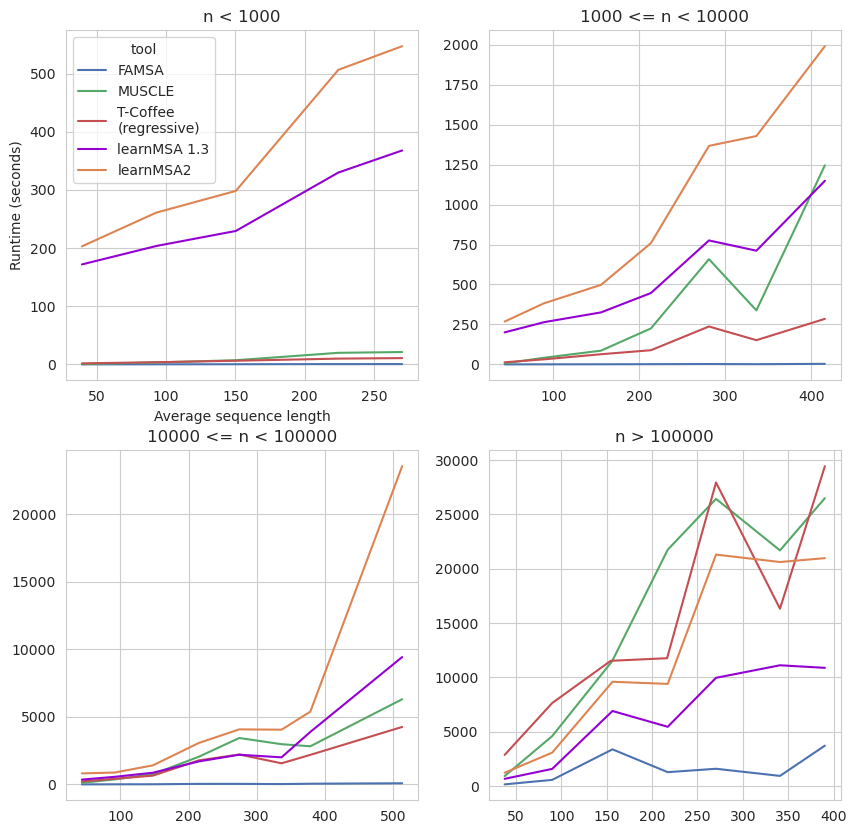

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
num_bins = [0, 1000, 10000, 100000, 100000000]
for i, ax in zip(range(len(num_bins)-1), axes.flatten()):
    if i == 0:
        ax.set_title(f"n < {num_bins[i+1]}")
    elif i == len(num_bins)-2:
        ax.set_title(f"n > {num_bins[i]}")
    else:
        ax.set_title(f"{num_bins[i]} <= n < {num_bins[i+1]}")
    runtime_lineplot((num_bins[i], num_bins[i+1]), ax)
    if i>0:
        ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")
    else:
        ax.set_xlabel("Average sequence length")
        ax.set_ylabel("Runtime (seconds)")

In [369]:
fig.savefig("plots/length_runtime.pdf", format="pdf", bbox_inches="tight")
fig.savefig("plots/length_runtime.png", format="png", bbox_inches="tight")

Text(0, 0.5, 'Runtime (seconds)')

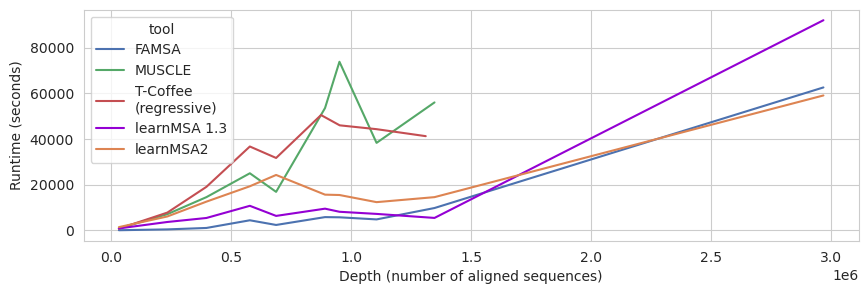

In [57]:
fig, ax = plt.subplots(1,1, figsize=(10, 3))
bins = np.linspace(0, 3e6, 20)
df = merged_df.copy()
#df = df[df.avg_len < 300]
df.tool = df.tool.astype('category')
df.tool = df.tool.cat.rename_categories(tool_name_map)
df.tool = df.tool.astype('object')
bins_df = df.groupby(["tool", pd.cut(df["num_seq"], bins)])
bins_df = bins_df[["tool", "avg_len", "max_len", "s/num_seq", "s", "max_rss", "num_seq"]].agg(
        {"tool" : "first", 
        "num_seq" : "mean",
        "avg_len" : "mean", 
        "max_len" : "mean", 
        "s/num_seq" : "mean", 
        "s" : "mean",
        "max_rss" : "mean"})
include_tools = ["learnMSA 1.3", "learnMSA2", "FAMSA", "MUSCLE", "T-Coffee\n(regressive)"]
bins_df = bins_df[bins_df["tool"].isin(include_tools)]
sns.lineplot(data=bins_df, x="num_seq", y="s", hue="tool", palette=tool_colors_barplot, ax=ax)
ax.set_xlabel("Depth (number of aligned sequences)")
ax.set_ylabel("Runtime (seconds)")

In [58]:
fig.savefig("plots/depth_runtime.pdf", format="pdf", bbox_inches="tight")
fig.savefig("plots/depth_runtime.png", format="png", bbox_inches="tight")

In [64]:
merged_df.sort_values("num_seq")

,dataset,family,num_seq,num_ref_seq,avg_len,avg_ref_len,sim,SP,modeler,TC,...,io_out,mean_load,cpu_time,tool,overlength,raw_dataset,max_len,min_len,s/num_seq,max_rss/num_seq
3582,homfam,seatoxin,93,5,43.6344,54,42.6,73.1,71.5,26.5,...,0.02,0.00,4.44,mafft_sparsecore,1.237556,homfam,50.0,34.0,0.006385,1.139032
3332,homfam,seatoxin,93,5,43.6344,54,42.6,82.9,81.2,55.1,...,0.02,0.00,4.45,muscle,1.237556,homfam,50.0,34.0,0.001291,1.160753
914,homfam,seatoxin,93,5,43.6344,54,42.6,73.6,71.9,34.7,...,0.52,117.95,227.80,learnMSA_paper,1.237556,homfam,50.0,34.0,2.037343,65.283333
333,homfam,seatoxin,93,5,43.6344,54,42.6,66.2,64.1,12.2,...,0.99,112.50,220.72,learnMSA,1.237556,homfam,50.0,34.0,2.069246,65.231828
1495,homfam,seatoxin,93,5,43.6344,54,42.6,74.8,72.6,38.8,...,4.74,122.37,269.37,learnMSA_language2,1.237556,homfam,50.0,34.0,2.329865,60.787097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,ext_homfam_huge,sdr,1369993,13,177.3620,361,23.3,69.3,83.0,34.7,...,14868.34,1210.47,993851.81,muscle,2.035385,ext_homfam_huge,297.0,22.0,0.059931,0.056550
1602,ext_homfam_huge,ABC_tran,2966699,6,169.2410,354,24.8,41.6,75.6,12.4,...,73682.46,573.34,337370.40,learnMSA_language2,2.091692,ext_homfam_huge,2277.0,18.0,0.019909,0.052345
2183,ext_homfam_huge,ABC_tran,2966699,6,169.2410,354,24.8,47.1,49.2,7.6,...,140578.16,3153.44,1973407.67,famsa,2.091692,ext_homfam_huge,2277.0,18.0,0.021094,0.008160
1021,ext_homfam_huge,ABC_tran,2966699,6,169.2410,354,24.8,36.4,74.9,8.9,...,49989.57,219.87,210193.39,learnMSA_paper,2.091692,ext_homfam_huge,2277.0,18.0,0.032224,0.013447


In [74]:
merged_df[merged_df.family =="egf"].iloc[:,:15]

,dataset,family,num_seq,num_ref_seq,avg_len,avg_ref_len,sim,SP,modeler,TC,column,s,h:m:s,max_rss,max_vms
62,ext_homfam_smallish,egf,93003,12,30.3664,71,31.1,63.9,68.7,26.5,24.0,436.6777,0:07:16,6317.41,125581.60
399,homfam,egf,7774,12,32.0765,71,31.1,80.2,80.9,44.1,48.5,197.0189,0:03:17,6128.58,125993.53
643,ext_homfam_smallish,egf,93003,12,30.3664,71,31.1,64.3,66.9,17.6,25.5,411.7335,0:06:51,6384.69,104959.18
980,homfam,egf,7774,12,32.0765,71,31.1,73.8,73.7,19.1,28.1,197.0383,0:03:17,6122.11,104815.24
1224,ext_homfam_smallish,egf,93003,12,30.3664,71,31.1,63.7,72.1,35.3,39.3,759.7884,0:12:39,7446.18,125751.48
1561,homfam,egf,7774,12,32.0765,71,31.1,78.7,81.9,36.8,41.9,383.1310,0:06:23,6464.49,125736.86
1805,ext_homfam_smallish,egf,93003,12,30.3664,71,31.1,66.5,67.1,14.7,25.5,15.2558,0:00:15,456.35,7250.88
2142,homfam,egf,7774,12,32.0765,71,31.1,76.8,75.8,25.0,38.3,0.5358,0:00:00,107.96,4602.93
2386,ext_homfam_smallish,egf,93003,12,30.3664,71,31.1,66.1,68.3,13.2,22.9,542.7813,0:09:02,1322.23,8031.66
2723,homfam,egf,7774,12,32.0765,71,31.1,75.5,74.6,23.5,35.7,21.2024,0:00:21,190.01,7074.75
